### Test of regularization with error network

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.core import Lambda
from keras.initializers import Constant
from keras.regularizers import l1, l2
from keras.datasets import mnist
from functools import partial

Using TensorFlow backend.


In [2]:
def get_kernel_reg(layer, errors, is_last, C, p, KLips = 1., lambda_ = 0.1):
    """ Get a DeltaNetwork regularizer for layer"""

    def kernel_reg(w, layer = layer, is_last = is_last, C_layer = C, p_layer = p, KLips = KLips, lambda_ = lambda_):
        """ Regularizer for a layer """
        # Maximal 1-norm over output neuron
        if layer == 0: return 0
        W = K.abs(w)

        print("Error is_last = %d %d = W(pC + K(1-p) DeltaOld) p = %f C = %s K = %f DeltaOld = %s W = %s" % (is_last, layer, p_layer, str(C_layer), KLips, str(errors[layer - 1]), str(W)))
        
        # error (induction)
        error = K.dot(K.transpose(W), p_layer * C_layer + KLips * (1 - p_layer) * errors[layer - 1])
        
        # saving the error for the next call
        errors[layer] = error

        # returning the error scaled
        return K.mean(error) * lambda_ if is_last else 0

    # returning the function
    return kernel_reg

In [3]:
# preparing dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28 ** 2)
x_test = x_test.reshape(-1, 28 ** 2)
digits = {x: [1 if y == x else 0 for y in range(10)] for x in range(10)}
y_train = np.array([digits[y] for y in y_train])
y_test = np.array([digits[y] for y in y_test])

In [4]:
# max per layer variable
C1 = K.variable(value = np.zeros((11, 1)))
C2 = K.variable(value = np.zeros((12, 1)))
C3 = K.variable(value = np.zeros((13, 1)))
C = [C1, C2, C3]

In [ ]:
# first layer of error network
errors = {0: K.variable(value = np.zeros((11, 1)))}

In [14]:
# defining the network
model = Sequential()
model.add(Dense(11, kernel_initializer = 'random_normal', activation = 'relu', input_shape = (784,)))
model.add(Dense(12, kernel_initializer = 'random_normal', activation = 'relu', kernel_regularizer = get_kernel_reg(1, errors, False, C1, 0.1, 2., 0)))
model.add(Dense(13, kernel_initializer = 'random_normal', activation = 'relu', kernel_regularizer = get_kernel_reg(2, errors, False, C2, 0.1, 2., 0)))
model.add(Dense(10, kernel_initializer = 'random_normal', activation = 'linear', kernel_regularizer = get_kernel_reg(3, errors, True, C3, 0.1, 2., 0.01)))

Error is_last = 0 1 = W(pC + K(1-p) DeltaOld) p = 0.100000 C = <tf.Variable 'Variable:0' shape=(11, 1) dtype=float32_ref> K = 2.000000 DeltaOld = <tf.Variable 'Variable_4:0' shape=(11, 1) dtype=float32_ref> W = Tensor("dense_6/weight_regularizer/Abs:0", shape=(11, 12), dtype=float32)
Error is_last = 0 2 = W(pC + K(1-p) DeltaOld) p = 0.100000 C = <tf.Variable 'Variable_1:0' shape=(12, 1) dtype=float32_ref> K = 2.000000 DeltaOld = Tensor("dense_6/weight_regularizer/MatMul:0", shape=(12, 1), dtype=float32) W = Tensor("dense_7/weight_regularizer/Abs:0", shape=(12, 13), dtype=float32)
Error is_last = 1 3 = W(pC + K(1-p) DeltaOld) p = 0.100000 C = <tf.Variable 'Variable_2:0' shape=(13, 1) dtype=float32_ref> K = 2.000000 DeltaOld = Tensor("dense_7/weight_regularizer/MatMul:0", shape=(13, 1), dtype=float32) W = Tensor("dense_8/weight_regularizer/Abs:0", shape=(13, 10), dtype=float32)


In [15]:
# calculating mean per neuron bound
inp = model.input
outputs = [K.mean(K.abs(layer.output), axis = 0) for layer in model.layers]
mean_per_neuron = lambda x : (K.function([inp, K.learning_phase()], outputs))([x, 1])

In [16]:
# calculating delta network output
delta_network = lambda x : (K.function([inp, K.learning_phase()], [K.mean(errors[3])]))([x, 1])[0]

In [17]:
# compiling the model
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy', 'mean_squared_error'])

In [18]:
# training the model
history = []
deltas = []
for i in range(100):
    history += [model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 1, batch_size = 30000)]
    for C_, v in zip(C, mean_per_neuron(x_train)):
        K.set_value(C_, v.reshape(-1, 1))
    deltas += [delta_network(x_train)]

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 6us/step - loss: 0.1340 - acc: 0.0911 - mean_squared_error: 0.1084 - val_loss: 0.1230 - val_acc: 0.1047 - val_mean_squared_error: 0.1002
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.1113 - acc: 0.1053 - mean_squared_error: 0.0994 - val_loss: 0.1086 - val_acc: 0.1054 - val_mean_squared_error: 0.0975
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.1081 - acc: 0.1075 - mean_squared_error: 0.0970 - val_loss: 0.1060 - val_acc: 0.1108 - val_mean_squared_error: 0.0956
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.1058 - acc: 0.1148 - mean_squared_error: 0.0951 - val_loss: 0.1037 - val_acc: 0.1264 - val_mean_squared_error: 0.0937
Train on 600

60000/60000 [==============================] - 0s 2us/step - loss: 0.0713 - acc: 0.4794 - mean_squared_error: 0.0648 - val_loss: 0.0705 - val_acc: 0.4788 - val_mean_squared_error: 0.0641
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.0704 - acc: 0.4951 - mean_squared_error: 0.0639 - val_loss: 0.0695 - val_acc: 0.4829 - val_mean_squared_error: 0.0631
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.0696 - acc: 0.4924 - mean_squared_error: 0.0631 - val_loss: 0.0696 - val_acc: 0.4773 - val_mean_squared_error: 0.0631
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.0696 - acc: 0.4936 - mean_squared_error: 0.0632 - val_loss: 0.0698 - val_acc: 0.4776 - val_mean_squared_error: 0.0634
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 

60000/60000 [==============================] - 0s 2us/step - loss: 0.0619 - acc: 0.5468 - mean_squared_error: 0.0564 - val_loss: 0.0588 - val_acc: 0.5877 - val_mean_squared_error: 0.0534
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.0592 - acc: 0.5889 - mean_squared_error: 0.0537 - val_loss: 0.0583 - val_acc: 0.5832 - val_mean_squared_error: 0.0529
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.0591 - acc: 0.5934 - mean_squared_error: 0.0536 - val_loss: 0.0594 - val_acc: 0.5635 - val_mean_squared_error: 0.0540
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 0s 2us/step - loss: 0.0599 - acc: 0.5880 - mean_squared_error: 0.0544 - val_loss: 0.0591 - val_acc: 0.5637 - val_mean_squared_error: 0.0537
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 

60000/60000 [==============================] - 0s 2us/step - loss: 0.0526 - acc: 0.6620 - mean_squared_error: 0.0467 - val_loss: 0.0526 - val_acc: 0.6433 - val_mean_squared_error: 0.0466


In [19]:
# obtaining accuracy
acc = [x for h in history for x in h.history['acc']]
val_acc = [x for h in history for x in h.history['val_acc']]

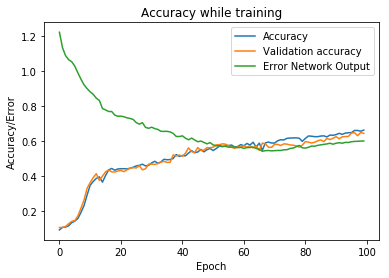

In [22]:
# plotting the training data
plt.figure()
plt.title('Accuracy while training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Error')
plt.plot(acc, label = 'Accuracy')
plt.plot(val_acc, label = 'Validation accuracy')
plt.plot(deltas, label = 'Error Network Output')
plt.legend()
plt.show()